In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

plt.style.use('default')
np.random.seed(0)

In [6]:
# Load data
california = fetch_california_housing(as_frame=True)
df = california.frame.copy()

print('Columns available:\n', df.columns.tolist())
print('\nShape of dataset:', df.shape)
print('\nFirst 5 rows:\n', df.head())

# Check statistics
print('\nStatistics:')
print(df.describe())

# Check data types
print('\nData Types:')
print(df.dtypes.to_string())

# Check missing values
print('\nMissing Values (count):')
print(df.isna().sum().sort_values(ascending=False).to_string())
print('\nMissing Values (%):')
print(df.isnull().mean().sort_values(ascending=False).to_string())

Columns available:
 ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

Shape of dataset: (20640, 9)

First 5 rows:
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     

### Basic cleaning

In [7]:
# Rename columns for readability
df = df.rename(columns={
    'MedInc': 'MedianIncome',
    'AveRooms': 'AvgRooms',
    'AveBedrms': 'AvgBedrooms',
    'AveOccup': 'AvgOccupancy',
    'MedHouseVal': 'MedianHouseValue'
})

### Basic EDA

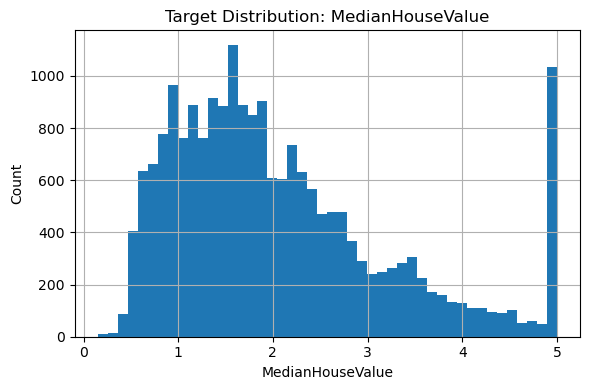

In [11]:
# 1. Target distribution
target = 'MedianHouseValue'

plt.figure(figsize=(6,4))
df[target].dropna().hist(bins='auto')
plt.title(f'Target Distribution: {target}')
plt.xlabel(target)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

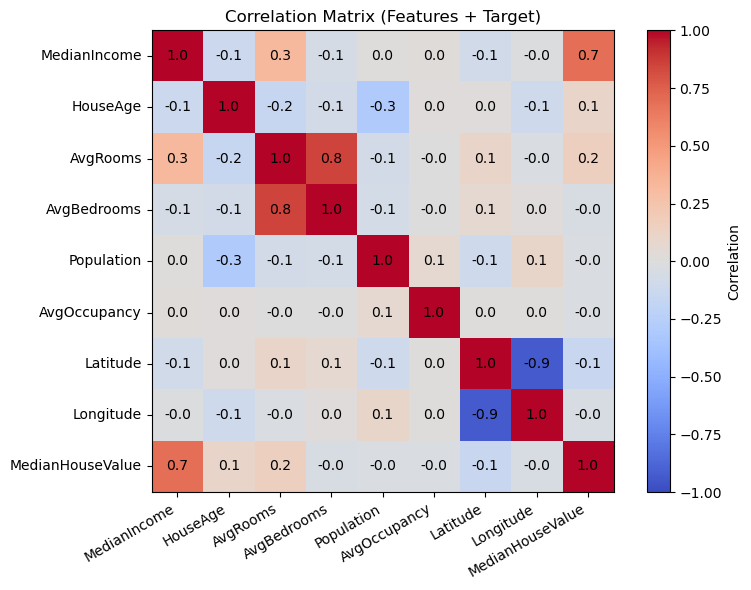

In [13]:
num_cols = df.select_dtypes(include=['float', 'int']).columns

# Correlation matrix
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')

# Display correlation values on the heatmap
for (i, j), val in np.ndenumerate(corr.values): 
    plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='black')
    
plt.colorbar(label='Correlation')
plt.xticks(range(len(num_cols)), num_cols, rotation=30, ha='right')
plt.yticks(range(len(num_cols)), num_cols, rotation=0, va='center')
plt.title('Correlation Matrix (Features + Target)')
plt.tight_layout()
plt.show()

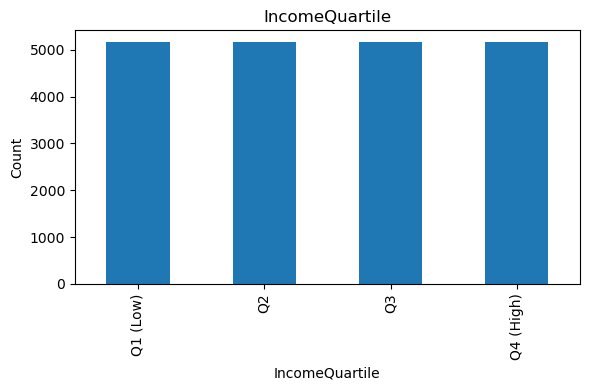

In [15]:
df['IncomeQuartile'] = pd.qcut(df['MedianIncome'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

# Categorical distributions
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for i, col in enumerate(cat_cols, 1):
    plt.figure(figsize=(6,4))
    df[col].dropna().value_counts().plot(kind='bar')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [17]:
# Drop rows with missing values for target column
critical_cols = target # Plus features for houses to calculate ratios
df_cleaned = df.dropna(subset=critical_cols).copy()

print('\nFinal dataset shape after cleaning:', df_cleaned.shape)
print('Remaining missing values:', df_cleaned.isnull().sum().sum())


Final dataset shape after cleaning: (20640, 10)
Remaining missing values: 0


### Feature engineering

Original features: 10
After feature engineering: 24

New feature sample (first 5 rows):
   log_Population  log_AvgRooms  log_AvgBedrooms  log_MedianIncome  \
0        5.777652      2.077455         0.704982          2.232720   
1        7.784057      1.979364         0.678988          2.230165   
2        6.208590      2.228738         0.729212          2.111110   
3        6.326149      1.919471         0.729025          1.893579   
4        6.338594      1.985385         0.732888          1.578195   

   RoomsPerHousehold  BedroomsPerRoom  PopPerHousehold  PeoplePerRoom  \
0           2.732919         0.146591            126.0      46.104545   
1           2.956685         0.155797           1138.0     384.890548   
2           2.957661         0.129516            177.0      59.844581   
3           2.283154         0.184458            219.0      95.919937   
4           2.879646         0.172096            259.0      89.941610   

   HouseholdDensity  Income_x_Age  Lat_x_Lon  Income

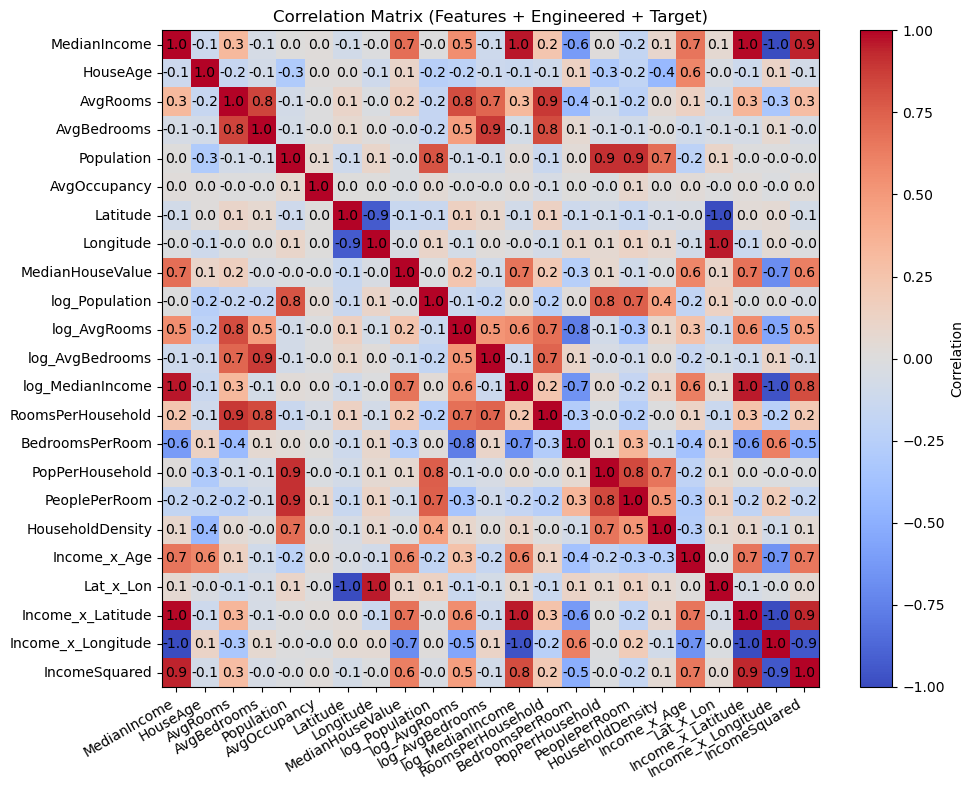

In [19]:
# Critical columns (all original features)
critical_cols = df.columns
df_cleaned = df.dropna(subset=critical_cols).copy()
df_fe = df_cleaned.copy()

# 1. Log transforms for skewed features
log_cols = ['Population', 'AvgRooms', 'AvgBedrooms', 'MedianIncome']
for col in log_cols:
    df_fe[f'log_{col}'] = np.log1p(df_fe[col])

# 2. Ratios
df_fe['RoomsPerHousehold'] = df_fe['AvgRooms'] / df_fe['AvgOccupancy']
df_fe['BedroomsPerRoom']   = df_fe['AvgBedrooms'] / df_fe['AvgRooms']
df_fe['PopPerHousehold']   = df_fe['Population'] / df_fe['AvgOccupancy']

# 3. Density features
df_fe['PeoplePerRoom']     = df_fe['Population'] / df_fe['AvgRooms']
df_fe['HouseholdDensity']  = df_fe['Population'] / df_fe['HouseAge']

# 4. Interaction features
df_fe['Income_x_Age'] = df_fe['MedianIncome'] * df_fe['HouseAge']

# 5. Geographic interactions
df_fe['Lat_x_Lon']          = df_fe['Latitude'] * df_fe['Longitude']
df_fe['Income_x_Latitude']  = df_fe['MedianIncome'] * df_fe['Latitude']
df_fe['Income_x_Longitude'] = df_fe['MedianIncome'] * df_fe['Longitude']

# 6. Polynomial feature
df_fe['IncomeSquared'] = df_fe['MedianIncome'] ** 2

print('Original features:', df_cleaned.shape[1])
print('After feature engineering:', df_fe.shape[1])

print('\nNew feature sample (first 5 rows):')
print(df_fe[[
    'log_Population', 'log_AvgRooms', 'log_AvgBedrooms', 'log_MedianIncome',
    'RoomsPerHousehold', 'BedroomsPerRoom', 'PopPerHousehold',
    'PeoplePerRoom', 'HouseholdDensity',
    'Income_x_Age',
    'Lat_x_Lon', 'Income_x_Latitude', 'Income_x_Longitude',
    'IncomeSquared'
]].head())

# Correlation of engineered features with target
num_cols_new = df_fe.select_dtypes(include=['float', 'int']).columns
corr_new = df_fe[num_cols_new].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr_new, vmin=-1, vmax=1, cmap='coolwarm')

# Display correlation values on the heatmap
for (i, j), val in np.ndenumerate(corr_new.values): 
    plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='black')

plt.colorbar(label='Correlation')
plt.xticks(range(len(num_cols_new)), num_cols_new, rotation=30, ha='right')
plt.yticks(range(len(num_cols_new)), num_cols_new, rotation=0, va='center')
plt.title('Correlation Matrix (Features + Engineered + Target)')
plt.tight_layout()
plt.show()

### Modeling

In [48]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

In [42]:
# 1. Features and target
cols_to_remove = {'MedianHouseValue', 'Population', 'AvgRooms', 'AvgBedrooms', 'MedianIncome', 'IncomeQuartile'}
features = [c for c in df_fe.columns if c not in cols_to_remove]
target = 'MedianHouseValue'
X = df_fe[features]
y = df_fe[target]

print('X shape:', X.shape, '| y shape:', y.shape)

# 2. Outer CV for unbiased evaluation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

# 3. Define models and inner CV search grids
models = {
    'Linear Regression': (
        Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('linearregression', LinearRegression())
        ]),
        {}  # no hyperparameters to tune
    ),
    'Ridge': (
        Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('ridge', Ridge(random_state=0))
        ]),
        {'ridge__alpha': [0.1, 1.0, 10.0]} 
    ),
    'Random Forest': (
        RandomForestRegressor(random_state=0, n_jobs=-1),
        {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        }
    ),
    'XGBoost': (
        XGBRegressor(
            objective='reg:squarederror',
            random_state=0,
            n_jobs=-1,
            verbosity=0
        ),
        {
            'n_estimators': [200, 500],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 6]
        }
    )
}

# 4. Nested CV loop
results = []
all_importances = {}
best_params = {name: [] for name in models.keys()}

for model_name, (estimator, param_grid) in models.items():
    fold_scores = []
    fold_importances = []

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # inner CV: tune hyperparameters (if grid not empty)
        if param_grid:
            search = GridSearchCV(
                estimator,
                param_grid=param_grid,
                scoring='r2',
                cv=3,
                n_jobs=-1
            )
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            best_params[model_name].append(search.best_params_)
        else:
            best_model = estimator
            best_model.fit(X_train, y_train)
            best_params[model_name].append({})

        # evaluate on outer fold
        y_pred = best_model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        fold_scores.append((rmse, r2))

        # collect coefficients / feature importances
        if model_name in ['Linear Regression', 'Ridge']:
            model_name_lower = model_name.lower().replace(' ', '')
            coefs = best_model.named_steps[model_name_lower].coef_
            fold_importances.append(pd.Series(coefs, index=features))
        elif model_name in ['Random Forest', 'XGBoost']:
            importances = best_model.feature_importances_
            fold_importances.append(pd.Series(importances, index=features))

    # average scores across outer folds
    rmse_mean = np.mean([s[0] for s in fold_scores])
    r2_mean   = np.mean([s[1] for s in fold_scores])
    results.append((model_name, rmse_mean, r2_mean))

    # average importances
    if fold_importances:
        all_importances[model_name] = pd.concat(fold_importances, axis=1).mean(axis=1).sort_values(ascending=False)

# 5. Baseline model (mean predictor) for reference
baseline_preds = np.repeat(y.mean(), len(y))  # global mean prediction
rmse_baseline = mean_squared_error(y, baseline_preds, squared=False)
r2_baseline   = r2_score(y, baseline_preds)
results.append(('Baseline', rmse_baseline, r2_baseline))

# 6. Summary table
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R2']).set_index('Model').round(3)
print('\nNested CV Results (5 outer folds):')
print(results_df)

# 7. Feature importances / coefficients
for model_name, imp in all_importances.items():
    print(f'\nTop features for {model_name}:')
    print(imp.head(10).to_string())

# 8. Show best params collected
print('\nBest hyperparameters across folds:')
for model, params in best_params.items():
    print(model, params)

X shape: (20640, 18) | y shape: (20640,)

Nested CV Results (5 outer folds):
                    RMSE     R2
Model                          
Linear Regression  0.664  0.669
Ridge              0.664  0.669
Random Forest      0.506  0.808
XGBoost            0.488  0.821
Baseline           1.154  0.000

Top features for Linear Regression:
Lat_x_Lon            2.378394
Latitude             1.245117
PopPerHousehold      0.322777
BedroomsPerRoom      0.288614
Income_x_Age         0.194861
RoomsPerHousehold    0.191178
HouseAge             0.012837
AvgOccupancy        -0.002363
log_AvgRooms        -0.004906
log_Population      -0.043655

Top features for Ridge:
Lat_x_Lon            2.109755
Latitude             1.028364
PopPerHousehold      0.322635
BedroomsPerRoom      0.289053
Income_x_Age         0.194529
RoomsPerHousehold    0.191179
HouseAge             0.013153
AvgOccupancy        -0.002404
log_AvgRooms        -0.004080
log_Population      -0.043647

Top features for Random Forest:
Inco

### Permutation importance for best model

Best parameters : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

Permutation importance - XGBoost:
Latitude              1.492169
Longitude             1.384609
Income_x_Longitude    0.403655
Lat_x_Lon             0.242222
AvgOccupancy          0.075680
Income_x_Age          0.049700
BedroomsPerRoom       0.042372
Income_x_Latitude     0.041848
RoomsPerHousehold     0.023545
log_MedianIncome      0.021400
log_AvgRooms          0.010764
HouseAge              0.007553
log_AvgBedrooms       0.006197
PopPerHousehold       0.004538
PeoplePerRoom         0.004073
HouseholdDensity      0.002735
log_Population        0.002134
IncomeSquared         0.000000


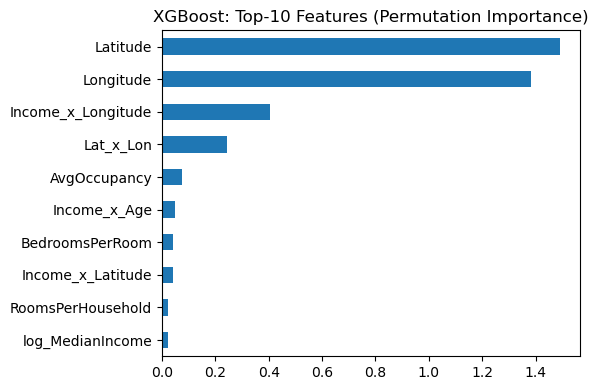

In [50]:
# Re-run GridSearch on the full dataset for XGBoost

param_grid = {
    'n_estimators': [200, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6]
}


search = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=0, n_jobs=-1, verbosity=0),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
search.fit(X, y)
print(f'Best parameters : {search.best_params_}')

# Permutation importance for XGBoost
imp = permutation_importance(search, X, y, n_repeats=10, random_state=0, n_jobs=-1)
imp_ser = pd.Series(imp.importances_mean, index=X.columns).sort_values(ascending=False)
print('\nPermutation importance - XGBoost:')
print(imp_ser.to_string())

plt.figure(figsize=(6, 4))

imp_ser.head(10)[::-1].plot(kind='barh') 
plt.title('XGBoost: Top-10 Features (Permutation Importance)')
plt.tight_layout()
plt.show()

### XGBoost reduced features

Reduced X shape: (20640, 11) | y shape: (20640,)

Nested CV Results (Reduced Features):
RMSE = 0.489, R² = 0.820


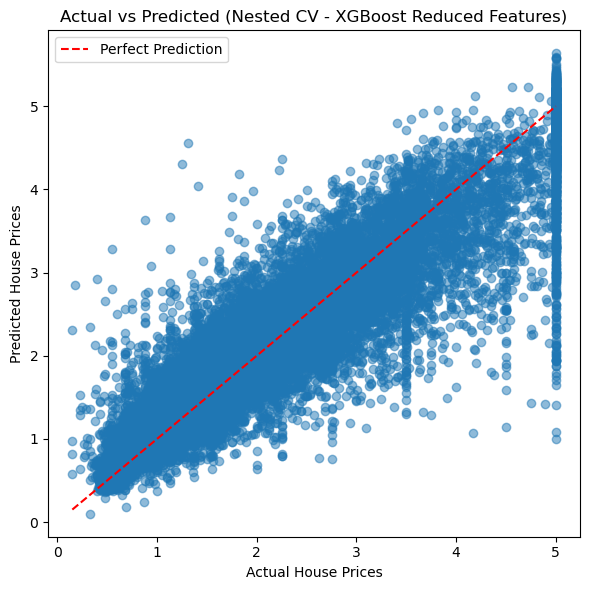

In [56]:
features_reduced = [
    'Latitude', 'Longitude',
    'Income_x_Longitude', 'Lat_x_Lon',
    'AvgOccupancy', 'Income_x_Age',
    'BedroomsPerRoom', 'Income_x_Latitude',
    'RoomsPerHousehold', 'log_MedianIncome', 'log_AvgRooms'
]

# 1. Features and target
X_reduced = df_fe[features_reduced]
y = df_fe['MedianHouseValue']

print('Reduced X shape:', X_reduced.shape, '| y shape:', y.shape)

# 2. Outer CV
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

# 3. Inner CV hyperparameter grid
param_grid = {
    'n_estimators': [200, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6]
}

# 4. Nested CV loop
results = []
all_y_true = []
all_y_pred = []

for train_idx, test_idx in outer_cv.split(X_reduced, y):
    X_train, X_test = X_reduced.iloc[train_idx], X_reduced.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inner CV for hyperparameter tuning
    search = GridSearchCV(
        XGBRegressor(
            objective='reg:squarederror',
            random_state=0,
            n_jobs=-1,
            verbosity=0
        ),
        param_grid=param_grid,
        scoring='r2',
        cv=3,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    y_pred = best_model.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Evaluate on outer fold
    y_pred = best_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results.append((rmse, r2))

# 5. Results
rmse_mean = np.mean([r[0] for r in results])
r2_mean   = np.mean([r[1] for r in results])

print('\nNested CV Results (Reduced Features):')
print(f'RMSE = {rmse_mean:.3f}, R² = {r2_mean:.3f}')

# 6. Scatterplot: Actual vs Predicted
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

plt.figure(figsize=(6,6))
plt.scatter(all_y_true, all_y_pred, alpha=0.5)
plt.plot([all_y_true.min(), all_y_true.max()],
         [all_y_true.min(), all_y_true.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Actual vs Predicted (Nested CV - XGBoost Reduced Features)')
plt.legend()
plt.tight_layout()
plt.show()